<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/11RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

# Scikit-learn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Download 10 years of Gold Fields stock data
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

# Keep required features (including Volume)
df = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()

# Create target variable: 1 if next day's close > today's close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop last row (since it has no next day target)
df = df.dropna()

df.tail()

/tmp/ipython-input-3287618951.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Target
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,
Date,,,,,,
2024-12-20,25710.158203,25726.155191,24762.336699,25351.225798,5006397,0
2024-12-23,24765.335938,25806.139923,24680.351943,25310.233317,1293370,1
2024-12-24,25406.214844,25571.183773,24765.335551,25085.275291,334453,0
2024-12-27,25074.277344,25918.118409,24735.341181,25105.271506,817916,0
2024-12-30,24805.328125,25098.272951,24517.382357,24827.323982,1012028,0


In [4]:
# Train: 2013-01-01 → 2023-12-31
train_df = df.loc["2013-01-01":"2023-12-31"]

# Test: 2024-01-01 → 2024-12-31
test_df = df.loc["2024-01-01":"2024-12-31"]

# Features and target
X_train = train_df[['Close', 'High', 'Low', 'Open', 'Volume']]
y_train = train_df['Target']

X_test = test_df[['Close', 'High', 'Low', 'Open', 'Volume']]
y_test = test_df['Target']


In [5]:
# Initialize and train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

Random Forest Accuracy: 0.5421686746987951

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.74      0.60       115
           1       0.62      0.37      0.47       134

    accuracy                           0.54       249
   macro avg       0.56      0.56      0.53       249
weighted avg       0.57      0.54      0.53       249



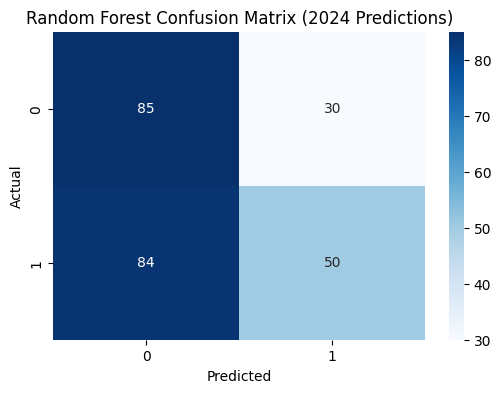

In [6]:
# Predict on test set (2024)
y_pred = rf_model.predict(X_test)

# Print evaluation metrics
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix (2024 Predictions)")
plt.show()


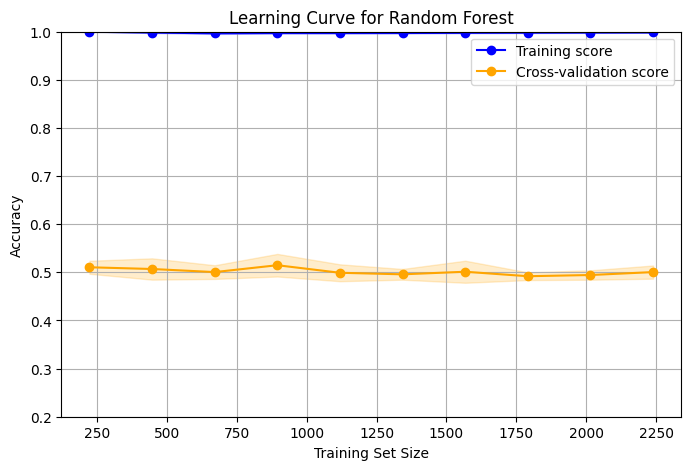

In [10]:
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="orange", label="Cross-validation score")

# Shaded areas for variance
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")

# Titles and labels
plt.title("Learning Curve for Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.ylim(0.2, 1.0)
plt.grid(True)
plt.show()


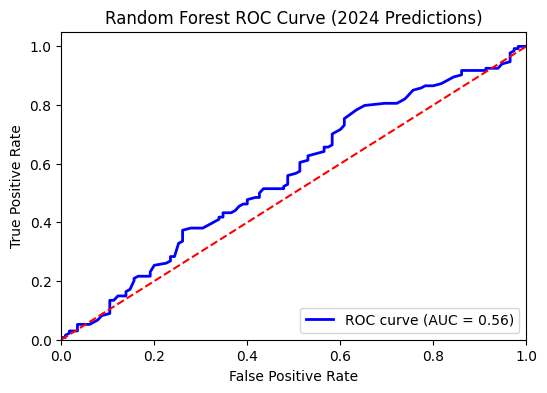

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (1)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")  # random baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve (2024 Predictions)")
plt.legend(loc="lower right")
plt.show()
